![](Capture.JPG)

# Problem Statement
Zbay is an E-commerce website which sells a variety of products at its online platform. Zbay records user behaviour of its customers and stores it as a log. However, most of the times, users do not buy the products instantly and there is a time gap during which the customer might surf the internet and maybe visit competitor websites.
 
Now, to improve sales of products, Zbay has hired Adiza, an Adtech company which built a system such that ads are being shown for Zbay’s products on its partner websites.
 
If a user comes to Zbay’s website and searches for a product, and then visits these partner websites or apps, his/her previously viewed items or their similar items are shown on as an ad. If the user clicks this ad, he/she will be redirected to the Zbay’s website and might buy the product.

![](zbay.JPG)
 
 
 
In this problem, the task is to predict click probability i.e. probability of user clicking the ad which is shown to them on the partner websites for the next 7 days on the basis of historical view log data, ad impression data and user data.
 
Provided with the view log of users (2018/10/15 - 2018/12/11) and the product description collected from the Zbay website. 
 
Train data contains the impression logs during 2018/11/15 – 2018/12/13 along with the label which specifies whether the ad is clicked or not. Model will be evaluated on the test data which have impression logs during 2018/12/12 – 2018/12/18 without the labels.


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
from sklearn.metrics import auc, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
from xgboost import XGBClassifier
from xgboost import plot_importance
from bayes_opt import BayesianOptimization
import xgboost as xgb

In [78]:
item_data = pd.read_csv('D:\DS\WNS Analytics Wizard 2019\item_data.csv')
view_log = pd.read_csv('D:/DS/WNS Analytics Wizard 2019/view_log.csv')
train = pd.read_csv('D:/DS/WNS Analytics Wizard 2019/train.csv')
test = pd.read_csv('D:/DS/WNS Analytics Wizard 2019/test.csv')

In [79]:
print(train.shape)
print(test.shape)
print(view_log.shape)
print(item_data.shape)

(237609, 7)
(90675, 6)
(3118622, 5)
(132761, 6)


In [80]:
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [81]:
test.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,latest,1
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,latest,1


In [82]:
view_log.head()

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [83]:
item_data.head()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


#### Merged view_log with item information

In [84]:
new_view_log = view_log.merge(item_data, how = 'left', on = 'item_id')
new_view_log.head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type
0,2018-10-15 08:58:00,android,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0
1,2018-10-15 08:58:00,android,503590,74788,7640,1376.0,7.0,71.0,228.0,545.0
2,2018-10-15 08:58:00,android,573960,23628,128855,4544.0,4.0,38.0,62.0,5609.0
3,2018-10-15 08:58:00,android,121691,2430,12774,904.0,17.0,39.0,252.0,2740.0
4,2018-10-15 08:58:00,android,218564,19227,28296,2304.0,12.0,57.0,54.0,7422.0


In [85]:
for i in new_view_log.columns:
    print(new_view_log[i].nunique(), ' ',i)

82840   server_time
3   device_type
1014970   session_id
89157   user_id
126708   item_id
13207   item_price
17   category_1
79   category_2
335   category_3
7846   product_type


### Feature extraction:
#### Top category_1 for individual user_id and category_count.

In [86]:
cat_count = new_view_log.groupby(['user_id','category_1'])['server_time'].count().reset_index().rename(columns = 
                                                                                             {'server_time':'category_count'})
cat_count = cat_count.sort_values('category_count', ascending = False)
cat_count = cat_count.drop_duplicates(subset = 'user_id', keep = 'first')
cat_count.head()

,user_id,category_1,category_count
521912,72172,17.0,485
479031,66239,4.0,241
481980,66654,16.0,234
252879,34934,4.0,227
581117,80432,9.0,224


In [87]:
train = train.merge(cat_count, how='left', on = 'user_id')
test = test.merge(cat_count, how = 'left', on = 'user_id')

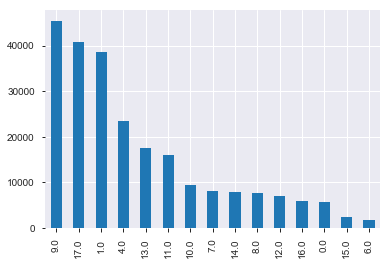

In [88]:
train.category_1.value_counts().plot(kind = 'bar')

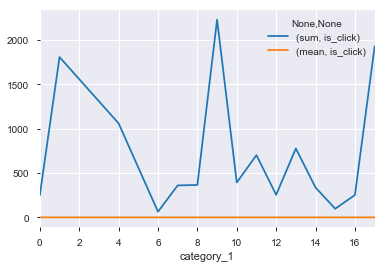

In [89]:
train.pivot_table(values = 'is_click', index = 'category_1', aggfunc = [sum, np.mean]).plot()

#### Top category_3 for individual user_id and category_count.

In [90]:
cat3_count = new_view_log.groupby(['user_id','category_3'])['server_time'].count().reset_index().rename(columns = 
                                                                                             {'server_time':'category3_count'})
cat3_count = cat3_count.sort_values('category3_count', ascending = False)
cat3_count = cat3_count.drop_duplicates(subset = 'user_id', keep = 'first')
cat3_count.head()

,user_id,category_3,category3_count
1088460,66654,256.0,234
1081654,66239,292.0,227
1176774,72172,292.0,193
571052,34934,292.0,153
467766,28675,264.0,145


In [91]:
train = train.merge(cat3_count, how='left', on = 'user_id')
test = test.merge(cat3_count, how = 'left', on = 'user_id')

#### Maximum viewed priduct and count

In [92]:
prod_count = new_view_log.groupby(['user_id','product_type'])['server_time'].count().reset_index().rename(columns = 
                                                                                             {'server_time':'prod_count',
                                                                                             'product_type':'prod'})
prod_count = prod_count.sort_values('prod_count', ascending = False)
prod_count = prod_count.drop_duplicates(subset = 'user_id', keep = 'first')
prod_count.head()

,user_id,prod,prod_count
1315871,66654,173.0,234
1307603,66239,2487.0,201
690302,34934,4524.0,146
564820,28675,2874.0,129
1422124,72172,9017.0,123


In [93]:
train = train.merge(prod_count, how='left', on = 'user_id')
test = test.merge(prod_count, how = 'left', on = 'user_id')

#### Peak hour for individual user_id and their view frequencies

In [94]:
log = new_view_log.join(new_view_log.server_time.str.split(' ', expand = True).add_prefix('T'))
log['T1'] = log['T1'].str.split(':', expand = True)
log['T1'] = log.T1.astype(int)
log = log.rename(columns={'T1':'Time0'})
log.head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type,T0,Time0
0,2018-10-15 08:58:00,android,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0,2018-10-15,8
1,2018-10-15 08:58:00,android,503590,74788,7640,1376.0,7.0,71.0,228.0,545.0,2018-10-15,8
2,2018-10-15 08:58:00,android,573960,23628,128855,4544.0,4.0,38.0,62.0,5609.0,2018-10-15,8
3,2018-10-15 08:58:00,android,121691,2430,12774,904.0,17.0,39.0,252.0,2740.0,2018-10-15,8
4,2018-10-15 08:58:00,android,218564,19227,28296,2304.0,12.0,57.0,54.0,7422.0,2018-10-15,8


In [95]:
time = log.groupby(['user_id','Time0'])['server_time'].count().reset_index().rename(columns = {'server_time':'time_count',
                                                                                              'Time0':'peak_hour'})
time.head()

,user_id,peak_hour,time_count
0,0,6,2
1,0,7,1
2,0,9,3
3,0,10,19
4,0,11,3


In [96]:
peak_hour = time.sort_values('time_count', ascending = False)
peak_hour = peak_hour.drop_duplicates(subset ='user_id', keep='first')
peak_hour = peak_hour.sort_values('user_id')
peak_hour.head()

,user_id,peak_hour,time_count
3,0,10,19
9,1,1,6
25,2,22,45
28,3,16,5
29,4,23,2


In [97]:
train = train.merge(peak_hour, on = 'user_id', how = 'left')
test = test.merge(peak_hour, on = 'user_id', how = 'left')

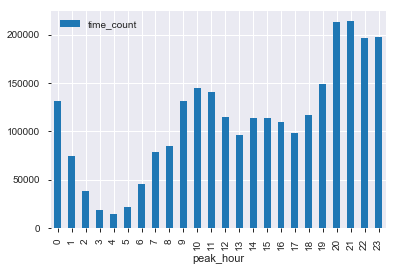

In [98]:
train.pivot_table(values = 'time_count', index = 'peak_hour',aggfunc = sum).plot(kind = 'bar')

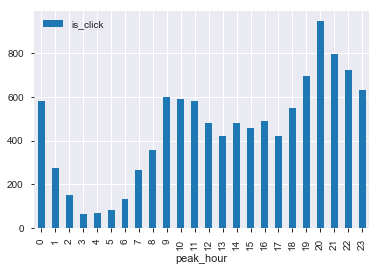

In [99]:
train.pivot_table(values = 'is_click', index = 'peak_hour', aggfunc = sum).plot(kind = 'bar')

#### Feature extraction from pricing information

In [100]:
price_info = new_view_log.groupby('user_id')['item_price'].agg(['max','min','mean','median','sum']).reset_index()
price_info.head()

,user_id,max,min,mean,median,sum
0,0,92160.0,332.0,9395.666667,3776.0,394618.0
1,1,12595.0,383.0,3946.750000,2070.0,31574.0
2,2,281536.0,128.0,14809.509091,3776.0,2443569.0
3,3,16640.0,537.0,7257.375000,2355.0,58059.0
4,4,58252.0,1977.0,30114.500000,30114.5,60229.0


In [101]:
train = train.merge(price_info, how = 'left', on = 'user_id')
test = test.merge(price_info, how = 'left', on = 'user_id')

#### Maximum viewed product and count

In [102]:
product_count = new_view_log.groupby('user_id')['product_type'].nunique().reset_index().rename(columns={
    'product_type':'product_count'})
product_count.head()

,user_id,product_count
0,0,18
1,1,8
2,2,126
3,3,3
4,4,2


In [103]:
train = train.merge(product_count, how='left',on='user_id')
test = test.merge(product_count, how='left',on='user_id')

#### Maximum viewed item and count

In [104]:
item_count = new_view_log.groupby('user_id')['item_id'].nunique().reset_index().rename(columns={
    'item_id':'item_count'})
item_count.head()

,user_id,item_count
0,0,18
1,1,8
2,2,130
3,3,3
4,4,2


In [105]:
train = train.merge(item_count, how='left',on='user_id')
test = test.merge(item_count, how='left',on='user_id')

#### Total number of unique session fot individual user

In [106]:
session_count = new_view_log.groupby('user_id')['session_id'].nunique().reset_index().rename(columns={
    'session_id':'session_count'})
session_count.head()

,user_id,session_count
0,0,11
1,1,3
2,2,37
3,3,1
4,4,1


In [107]:
train = train.merge(session_count, how='left',on='user_id')
test = test.merge(session_count, how='left',on='user_id')

#### Total views in view_log for individual user

In [108]:
view_count = new_view_log.groupby('user_id').count().reset_index()
view_count = view_count.loc[:,['user_id','server_time']]
view_count = view_count.rename(columns={'server_time':'view_count'})
view_count.head()

,user_id,view_count
0,0,42
1,1,8
2,2,165
3,3,8
4,4,2


In [109]:
train = train.merge(view_count, how = 'left', on = 'user_id')
test = test.merge(view_count, how = 'left', on = 'user_id')

#### Device type for individual user

In [110]:
device_type = new_view_log.loc[:,['user_id', 'device_type']]
device_type.drop_duplicates(subset = 'user_id', inplace = True)
device_type.head()

,user_id,device_type
0,4557,android
1,74788,android
2,23628,android
3,2430,android
4,19227,android


In [111]:
train = train.merge(device_type, how = 'left', on = 'user_id')
test = test.merge(device_type, how = 'left', on = 'user_id')

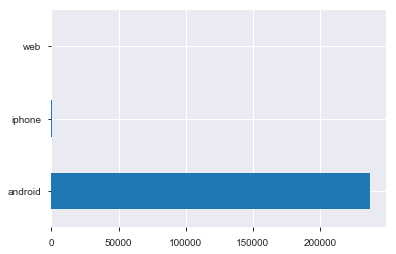

In [112]:
train.device_type.value_counts().plot(kind = 'barh')

#### Feature extraction from datetime column

In [113]:
train = train.join(train.impression_time.str.split(' ',expand = True).add_prefix('Date'))
test = test.join(test.impression_time.str.split(' ',expand = True).add_prefix('Date'))

In [114]:
def extractDateFeature(date_column,data):
    data[date_column+'_day'] = data[date_column].dt.day
    data[date_column+'_month'] = data[date_column].dt.month
    data[date_column+'_dayofweek'] = data[date_column].dt.dayofweek
    data[date_column+'_isweekend'] = data[date_column+'_dayofweek'].apply(lambda x:1 if x ==5 or x ==6 else 0)
    return data

In [115]:
train['Date0'] = pd.to_datetime(train.Date0, format = '%Y-%m-%d') 
test['Date0'] = pd.to_datetime(test.Date0, format = '%Y-%m-%d') 

In [116]:
train = extractDateFeature('Date0',train)
test = extractDateFeature('Date0',test)

In [117]:
pd.pivot_table(train, values='is_click', index='Date0_dayofweek', aggfunc = [len, sum, np.mean])

,len,sum,mean
,is_click,is_click,is_click
Date0_dayofweek,,,
0,34948,1632,0.046698
1,43946,1890,0.043007
2,30797,1371,0.044517
3,33989,1559,0.045868
4,30941,1384,0.044730
5,31306,1506,0.048106
6,31682,1520,0.047977


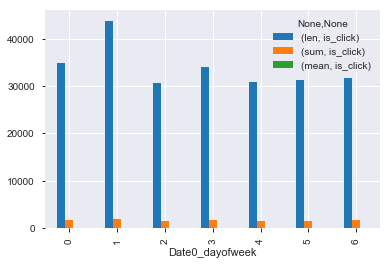

In [118]:
pd.pivot_table(train, values='is_click', index='Date0_dayofweek', aggfunc = [len, sum, np.mean]).plot(kind ='bar')

In [119]:
pd.pivot_table(train, values='is_click', index='Date0_isweekend', aggfunc = [len, sum, np.mean])

,len,sum,mean
,is_click,is_click,is_click
Date0_isweekend,,,
0,174621,7836,0.044874
1,62988,3026,0.048041


#### User behavior and click percentage for individual's peak hour and every 1 hour gap from peak hour.

In [120]:
train = train.join(train.Date1.str.split(':', expand = True).add_prefix('Time'))
train.Time0 = train.Time0.astype(int)
test = test.join(test.Date1.str.split(':', expand = True).add_prefix('Time'))
test.Time0 = test.Time0.astype(int)

In [121]:
train['peak_gap'] = abs(train.peak_hour - train.Time0)
test['peak_gap'] = abs(test.peak_hour - test.Time0)

In [122]:
pd.pivot_table(train, index = 'peak_gap', values = 'is_click', aggfunc = [len, sum, np.mean])

,len,sum,mean
,is_click,is_click,is_click
peak_gap,,,
0,16242,1365,0.084041
1,24986,1196,0.047867
2,20920,909,0.043451
3,18480,776,0.041991
4,16182,658,0.040662
5,14617,670,0.045837
6,14066,562,0.039955
7,13564,578,0.042613


#### Peak hour and impression time analysis

In [123]:
best_time = []
for i in train.peak_gap:
    if i == 0:
        best_time.append(1)
    else:
        best_time.append(0)
best_time_t = []
for i in test.peak_gap:
    if i == 0:
        best_time_t.append(1)
    else:
        best_time_t.append(0)
        
train['best_time'] = best_time
test['best_time'] = best_time_t

In [124]:
train.loc[:,['peak_gap', 'best_time']].head()

,peak_gap,best_time
0,18,0
1,5,0
2,12,0
3,18,0
4,22,0


In [125]:
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,category_1,category_count,category_3,category3_count,prod,prod_count,peak_hour,time_count,max,min,mean,median,sum,product_count,item_count,session_count,view_count,device_type,Date0,Date1,Date0_day,Date0_month,Date0_dayofweek,Date0_isweekend,Time0,Time1,Time2,peak_gap,best_time
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,11.0,1.0,20.0,1.0,5622.0,1.0,18,1,2350.0,2350.0,2350.000000,2350.0,2350.0,1,1,1,1,android,2018-11-15,00:00:00,15,11,3,0,0,00,00,18,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,4.0,6.0,292.0,6.0,577.0,5.0,5,3,14166.0,1024.0,4452.833333,3421.0,53434.0,7,7,7,12,android,2018-11-15,00:01:00,15,11,3,0,0,01,00,5,0
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,13.0,1.0,170.0,1.0,2325.0,1.0,12,2,2224.0,973.0,1598.500000,1598.5,3197.0,2,2,2,2,android,2018-11-15,00:02:00,15,11,3,0,0,02,00,12,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,14.0,3.0,220.0,3.0,7093.0,3.0,18,5,93568.0,249.0,9963.388889,2307.0,179341.0,12,12,7,18,android,2018-11-15,00:02:00,15,11,3,0,0,02,00,18,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,17.0,9.0,279.0,6.0,1961.0,5.0,22,9,117376.0,288.0,8618.934783,3596.5,396471.0,34,34,24,46,android,2018-11-15,00:02:00,15,11,3,0,0,02,00,22,0


In [126]:
test.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,category_1,category_count,category_3,category3_count,prod,prod_count,peak_hour,time_count,max,min,mean,median,sum,product_count,item_count,session_count,view_count,device_type,Date0,Date1,Date0_day,Date0_month,Date0_dayofweek,Date0_isweekend,Time0,Time1,Time2,peak_gap,best_time
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1,1.0,1.0,220.0,1.0,1617.0,1.0,19,1,23424.0,23424.0,23424.000000,23424.0,23424.0,1,1,1,1,android,2018-12-13,07:44:00,13,12,3,0,7,44,00,12,0
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0,1.0,14.0,157.0,9.0,9227.0,4.0,21,20,54681.0,207.0,10752.375000,3840.0,774171.0,42,46,25,72,android,2018-12-13,07:45:00,13,12,3,0,7,45,00,14,0
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1,7.0,2.0,4.0,2.0,60.0,2.0,10,3,20309.0,1238.0,4974.555556,2116.0,44771.0,7,7,6,9,android,2018-12-13,07:46:00,13,12,3,0,7,46,00,3,0
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,latest,1,9.0,10.0,262.0,8.0,2455.0,8.0,14,9,62976.0,249.0,15009.297297,5248.0,555344.0,16,17,12,37,android,2018-12-13,07:47:00,13,12,3,0,7,47,00,7,0
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,latest,1,11.0,5.0,148.0,3.0,5000.0,3.0,10,12,43392.0,435.0,8778.285714,3105.0,245792.0,26,26,18,28,android,2018-12-13,07:48:00,13,12,3,0,7,48,00,3,0


In [10]:
train.profile_report(style={'full_width':True, 'theme':'flatly'})

In [127]:
train = pd.get_dummies(train, columns = ['os_version','device_type'])
test = pd.get_dummies(test, columns = ['os_version','device_type'])

In [128]:
print(train.shape)
print(test.shape)

(237609, 38)
(90675, 37)


In [129]:
train.head()

,impression_id,impression_time,user_id,app_code,is_4G,is_click,category_1,category_count,category_3,category3_count,prod,prod_count,peak_hour,time_count,max,min,mean,median,sum,product_count,item_count,session_count,view_count,device_type,Date0,Date1,Date0_day,Date0_month,Date0_dayofweek,Date0_isweekend,Time0,Time1,Time2,peak_gap,best_time,os_version_intermediate,os_version_latest,os_version_old
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,0,0,11.0,1.0,20.0,1.0,5622.0,1.0,18,1,2350.0,2350.0,2350.000000,2350.0,2350.0,1,1,1,1,android,2018-11-15,00:00:00,15,11,3,0,0,00,00,18,0,0,0,1
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,1,1,4.0,6.0,292.0,6.0,577.0,5.0,5,3,14166.0,1024.0,4452.833333,3421.0,53434.0,7,7,7,12,android,2018-11-15,00:01:00,15,11,3,0,0,01,00,5,0,0,1,0
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,1,0,13.0,1.0,170.0,1.0,2325.0,1.0,12,2,2224.0,973.0,1598.500000,1598.5,3197.0,2,2,2,2,android,2018-11-15,00:02:00,15,11,3,0,0,02,00,12,0,1,0,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,1,0,14.0,3.0,220.0,3.0,7093.0,3.0,18,5,93568.0,249.0,9963.388889,2307.0,179341.0,12,12,7,18,android,2018-11-15,00:02:00,15,11,3,0,0,02,00,18,0,0,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,0,0,17.0,9.0,279.0,6.0,1961.0,5.0,22,9,117376.0,288.0,8618.934783,3596.5,396471.0,34,34,24,46,android,2018-11-15,00:02:00,15,11,3,0,0,02,00,22,0,0,1,0


In [134]:
skip =['impression_id', 'impression_time','Date0','Date1','Date0_month','Date0_day','Time1', 'Time2']

y = ['is_click']
X = [x for x in train.columns if x not in y+skip]
xtr = train[X]
xts = test[X]
ytr = train[y]

xtr, xv, ytr, yv = train_test_split(xtr, ytr, test_size = 0.30, random_state = 0)
print(xtr.shape)
print(xv.shape)
print(ytr.shape)
print(yv.shape)
train_data = lgb.Dataset(xtr, label = ytr)
val_data = lgb.Dataset(xv, label = yv)

(166326, 31)
(71283, 31)
(166326, 1)
(71283, 1)


In [151]:
param = {"num_leaves": 3, 
         "learning_rate": 0.1,
         "objective":'binary', 
         "scale_pos_weight": 1.10,
         "metric": 'auc',
        "bagging_fraction" : 1,
        "feature_fraction" : 1,
       # "bagging_freq" : 5,
        "reg_alpha" : 4.55,
        "reg_lambda" : 3.50,
        "random_state" : 0,
       # "bagging_seed" : 200,
        "verbosity" : -1,
        "max_depth": 2,
        "min_child_samples": 10,
        "save_binary": True}
mlgb = lgb.train(param, train_data, 500000, valid_sets = [train_data,val_data],
                 early_stopping_rounds =50,  verbose_eval = 5000)

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1118]	training's auc: 0.747707	valid_1's auc: 0.722472


In [137]:
print('Training confusion matrix:')
ytr_lgb = mlgb.predict(xtr, num_iteration = mlgb.best_iteration)
ytr_lgb = np.round(ytr_lgb)
print('AUC',roc_auc_score(ytr, ytr_lgb))
print(confusion_matrix(ytr, ytr_lgb))

print('Validation confusion matrix:')
yv_lgb = mlgb.predict(xv, num_iteration = mlgb.best_iteration)
yv_lgb = np.round(yv_lgb)
print('AUC',roc_auc_score(yv, yv_lgb))
print(confusion_matrix(yv, yv_lgb))

Training confusion matrix:
AUC 0.5512396080422184
[[158138    519]
 [  6858    811]]
Validation confusion matrix:
AUC 0.5147505141980385
[[67753   337]
 [ 3083   110]]


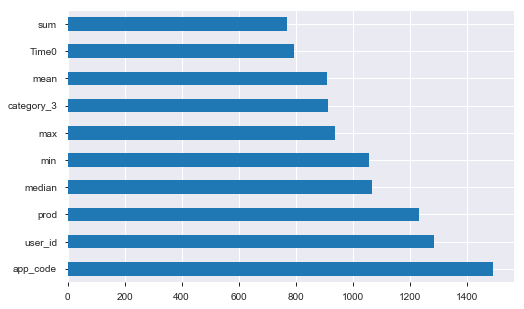

In [138]:
feature_imp = pd.Series(mlgb.feature_importance(), index=xtr.columns)
feature_imp.nlargest(10).plot(kind='barh', figsize=(8,5))

In [146]:
def bayes_parameter_opt_lgb(xtr, ytr, init_round=10, opt_round=20, n_folds=2, n_estimators=500000,output_process=False,
                           bagging_fraction = 1):
    train_data = lgb.Dataset(xtr, label = ytr)
    def lgb_crossval(num_leaves,max_depth,learning_rate,feature_fraction,reg_alpha,reg_lambda,min_child_samples,
                     scale_pos_weight):
        params = { "objective":'binary',
             "num_leaves": int(num_leaves),
             "learning_rate": learning_rate,
             "num_iterations": n_estimators,
             "metric": 'auc',
             "scale_pos_weight": scale_pos_weight,
             "bagging_fraction" : bagging_fraction,
             "feature_fraction" : max(min(feature_fraction,1), 0),
             "reg_alpha" : max(reg_alpha,0),
             "reg_lambda" : max(reg_lambda,0),
             "random_state" : 0,
             "verbosity" : -1,
             "max_depth": int(max_depth),
             "min_child_samples": int(min_child_samples),
             "early_stopping_round": 1000,
             "save_binary": True}
        cv_result = lgb.cv(params, train_data, nfold = n_folds, stratified = True, verbose_eval = 500000, 
                           metrics = ['auc'])
        return max(cv_result['auc-mean'])
    lgb_opt = BayesianOptimization(lgb_crossval,{"num_leaves":(5,120),
                                            "max_depth":(4,25),
                                            "learning_rate":(0.03,0.9),
                                            "feature_fraction":(0.1,1),
                                            "reg_alpha":(1,7.5),
                                            "reg_lambda":(1,7.5),
                                            "scale_pos_weight": (0.1,7.5),
                                            "min_child_samples":(5,200)},
                                            random_state = 0)
    lgb_opt.maximize(init_points = init_round, n_iter = opt_round)
    return lgb_opt.max
opt_params = bayes_parameter_opt_lgb(xtr, ytr, init_round=5, opt_round=25, n_folds=2, n_estimators=500000)

|   iter    |  target   | featur... | learni... | max_depth | min_ch... | num_le... | reg_alpha | reg_la... | scale_... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.675    |  0.5939   |  0.6522   |  16.66    |  111.3    |  53.72    |  5.198    |  3.844    |  6.699    |
|  2        |  0.7032   |  0.9673   |  0.3636   |  20.63    |  108.1    |  70.33    |  7.016    |  1.462    |  0.7448   |
|  3        |  0.6638   |  0.1182   |  0.7544   |  20.34    |  174.7    |  117.5    |  6.195    |  4.0      |  5.876    |
|  4        |  0.6739   |  0.2064   |  0.5867   |  7.01     |  189.2    |  65.01    |  3.695    |  2.72     |  5.829    |
|  5        |  0.6972   |  0.5105   |  0.5245   |  4.395    |  125.4    |  75.39    |  5.01     |  7.134    |  5.145    |
|  6        |  0.713    |  1.0      |  0.03     |  4.0      |  5.0      |  120.0    |  1.0      |  1.0      |  0.1      |
|  7        |  0.7066   

In [147]:
opt_params

{'target': 0.7163638645745863,
 'params': {'feature_fraction': 0.3573069812250008,
  'learning_rate': 0.14525317113892472,
  'max_depth': 24.876119855245904,
  'min_child_samples': 119.37872133410573,
  'num_leaves': 104.56822117168956,
  'reg_alpha': 2.5149589225446007,
  'reg_lambda': 4.941610811897999,
  'scale_pos_weight': 0.32160857821860833}}

In [149]:
param = {"num_leaves": 105, #21
         "learning_rate": 0.14525317113892472,
         "objective":'binary', 
         "scale_pos_weight": 0.32160857821860833,
         "metric": 'auc',
        "bagging_fraction" : 1,
        "feature_fraction" : 0.3573069812250008,
       # "bagging_freq" : 5,
        "reg_alpha" : 2.5149589225446007,
        "reg_lambda" : 4.941610811897999,
        "random_state" : 0,
       # "bagging_seed" : 200,
        "verbosity" : -1,
        "max_depth": 25,
        "min_child_samples": 119,
        "save_binary": True}
mlgb = lgb.train(param, train_data, 500000, valid_sets = [train_data,val_data],
                 early_stopping_rounds =200,  verbose_eval = 1000)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[113]	training's auc: 0.855632	valid_1's auc: 0.739265
